In [77]:
import PIL
import kornia
import glob
import torch
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
from torchvision import transforms as T
from networks.ResnetFaceSTN import ResnetFaceSTN
from pathlib import Path
from skimage.transform import resize

## Transform Definitions

In [2]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

    
transform = T.Compose(
    [
        T.Resize((128, 128)),
        T.ToTensor(),
        T.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
    ]
)

## Weight Paths and Image Paths
Weight paths

In [69]:
ROOT_LFW = Path("datasets/eval/data/lfw/lfw_masked")

WEIGHT_PATH = "weights/mask_exp19-resnetSTN/epoch_18/mask_exp19-resnetSTN_ep18.pth"

P1 = "Alfredo_Moreno/Alfredo_Moreno_0001.jpg"
P2 = "Dyab_Abou_Jahjah/Dyab_Abou_Jahjah_0001.jpg"

In [70]:
def stn_forward(weight_path, img_path):
    net = ResnetFaceSTN(stn_mode='resnet')
    net.load_state_dict(torch.load(weight_path))
    net.eval()

    unorm = UnNormalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

    img = PIL.Image.open(img_path)
    img_t = transform(img).unsqueeze(0)
    img_stn = net.stn(img_t)
    img_p = kornia.tensor_to_image(unorm(img_stn.clone().detach()))
    
    return img_p

## Preview

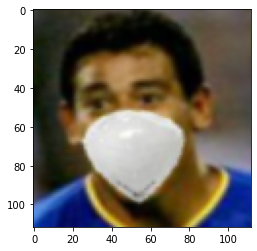

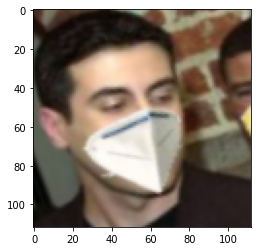

In [71]:
img_p = stn_forward(WEIGHT_PATH, ROOT_LFW / P1)
plt.imshow(img_p)
plt.show()
# plt.imsave("pair_sample_result/NEG_mCASIAC_P1_2.jpg", img_p)

img_p = stn_forward(WEIGHT_PATH, ROOT_LFW / P2)
plt.imshow(img_p)
plt.show()
# plt.imsave("pair_sample_result/NEG_mCASIAC_P2_2.jpg", img_p)

In [81]:
sample_images_masked = glob.glob('image_samples/LFW-Masked/*.jpg')
sample_images = glob.glob('image_samples/LFW/*.jpg')

top_row = []
bottom_row = []
for i, imgs in enumerate(zip(sample_images_masked, sample_images), 1):
    masked_img, norm_img = imgs
    
    # img_a = stn_forward(WEIGHT_PATH, masked_img)
    img_a = stn_forward(WEIGHT_PATH, norm_img)

    # img_o = plt.imread(masked_img)
    img_o = plt.imread(norm_img)
    img_o = resize(np.array(img_o), (112, 112), anti_aliasing=True)

    if len(top_row) == 0: top_row = img_o
    else: top_row = np.hstack((top_row, img_o))
    
    if len(bottom_row) == 0: bottom_row = np.array(img_a)
    else: bottom_row = np.hstack((bottom_row, img_a))
    
aligned_img = np.vstack((top_row, bottom_row))
plt.imsave("pair_sample_result/nonmask_ori_align.jpg", aligned_img)